In [1]:
# importing modules
import dvc.api
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import mlflow
from IPython.display import Markdown, display, Image
import warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(os.path.join('..')))

2022-05-29 17:06:28.237902: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-29 17:06:28.237940: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# importing scripts
import sys
sys.path.insert(0,'../scripts/')
from data_manipulator import DataManipulator
from data_exploration import exploration
from ltsm_model import ltsm_time

# Importing Unlabeled data from DVC

In [4]:
#Importing the collected Data
path = 'data/train_store.csv'
repo = 'https://github.com/Abel-Blue/pharmaceutical-sales-prediction'
rev = 'v3-scaled'
data_url = dvc.api.get_url(path=path, repo=repo, rev=rev)
scaled = pd.read_csv(data_url)

In [5]:
scaled.head()

,DayOfWeek,WeekDay,Year,Month,Season,Day,MonthTiming,Sales,Customers,Open,...,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalesPerCustomer,CompetitionOpenSince
0,0.501484,0.630672,1.502077,0.346724,0.389712,1.740766,1.205894,-0.063134,-0.067027,0.452399,...,-0.940975,-0.538742,0.436247,-0.385752,-1.001128,-0.421904,-0.305054,0.045131,-0.093996,0.595717
1,0.000831,0.630672,1.502077,0.346724,0.389712,1.626969,1.205894,-0.136239,-0.092863,0.452399,...,-0.940975,-0.538742,0.436247,-0.385752,-1.001128,-0.421904,-0.305054,0.045131,-0.207208,0.595717
2,-0.499823,0.630672,1.502077,0.346724,0.389712,1.513173,1.205894,-0.207840,-0.158887,0.452399,...,-0.940975,-0.538742,0.436247,-0.385752,-1.001128,-0.421904,-0.305054,0.045131,-0.227101,0.595717
3,-1.000476,0.630672,1.502077,0.346724,0.389712,1.399377,1.205894,-0.138946,-0.052674,0.452399,...,-0.940975,-0.538742,0.436247,-0.385752,-1.001128,-0.421904,-0.305054,0.045131,-0.303632,0.595717
4,-1.501129,0.630672,1.502077,0.346724,0.389712,1.285581,1.205894,0.189274,0.096598,0.452399,...,-0.940975,-0.538742,0.436247,-0.385752,-1.001128,-0.421904,-0.305054,0.045131,0.097227,0.595717


In [6]:
train = pd.read_csv('../data/train.csv')
train = train[['Date','Sales']]
train = train.groupby('Date').agg({'Sales':'mean'})

In [7]:
train.head()

,Sales
Date,
2013-01-01,87.284560
2013-01-02,6233.030493
2013-01-03,5693.112108
2013-01-04,5954.218834
2013-01-05,5337.751570


# Scale sales

In [8]:
manu = DataManipulator(train)

In [9]:
# Using StandardScaler to standardize the all columns
scale_list = train.columns.to_list()
manu.standardize_columns(scale_list)

,Sales
Date,
2013-01-01,-1.972829
2013-01-02,0.155989
2013-01-03,-0.031033
2013-01-04,0.059412
2013-01-05,-0.154126
...,...
2015-07-27,1.323292
2015-07-28,0.828649
2015-07-29,0.637557


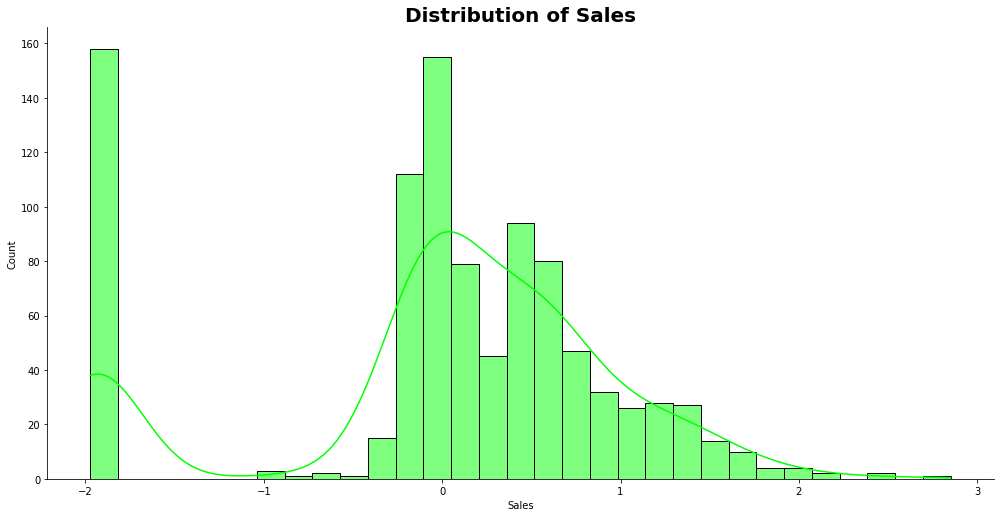

In [10]:
exploration.plot_hist(train, 'Sales', 'lime') 

In [11]:
train["Sales"] = train["Sales"].astype("float")

In [12]:
train["Sales"].isna().any().sum()

0

In [13]:
SIZE = len(train["Sales"])
WINDOW_SIZE = 49
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

t = ltsm_time(WINDOW_SIZE, BATCH_SIZE, train)

2022-05-29 17:10:07.467357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-29 17:10:07.467406: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-29 17:10:07.467439: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (abel-linux): /proc/driver/nvidia/version does not exist
2022-05-29 17:10:07.526612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022/05/29 17:11:00 INFO mlflow.tracking.fluent: Experiment with name 'Rossman-Lstm_model' does not exist. Creating a new experiment.
2022/05/29 17:11:00 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 20)          1760      
                                                                 
 lstm_1 (LSTM)               (None, 10)                1240      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 3,011
Trainable params: 3,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1/1 [==============================] - 9s 9s/step - loss: 0.4138 - val_loss: 0.3958
Epoch 2/200
1/1 [==============================] - 0s 312ms/step - loss: 0.4121 - val_loss: 0.3932
Epoch 3/200
1/1 [==============================] - 0s 333ms/step - loss: 0.4104 - val_loss: 0.3907
Epoch 4/200
1/1 [=======

Epoch 75/200
1/1 [==============================] - 0s 307ms/step - loss: 0.3821 - val_loss: 0.3291
Epoch 76/200
1/1 [==============================] - 0s 305ms/step - loss: 0.3818 - val_loss: 0.3289
Epoch 77/200
1/1 [==============================] - 0s 338ms/step - loss: 0.3815 - val_loss: 0.3287
Epoch 78/200
1/1 [==============================] - 0s 312ms/step - loss: 0.3811 - val_loss: 0.3286
Epoch 79/200
1/1 [==============================] - 0s 315ms/step - loss: 0.3808 - val_loss: 0.3285
Epoch 80/200
1/1 [==============================] - 0s 308ms/step - loss: 0.3805 - val_loss: 0.3284
Epoch 81/200
1/1 [==============================] - 0s 301ms/step - loss: 0.3801 - val_loss: 0.3283
Epoch 82/200
1/1 [==============================] - 0s 310ms/step - loss: 0.3798 - val_loss: 0.3281
Epoch 83/200
1/1 [==============================] - 0s 306ms/step - loss: 0.3794 - val_loss: 0.3280
Epoch 84/200
1/1 [==============================] - 0s 316ms/step - loss: 0.3790 - val_loss: 0.3278


1/1 [==============================] - 0s 305ms/step - loss: 0.3201 - val_loss: 0.2524
Epoch 157/200
1/1 [==============================] - 0s 314ms/step - loss: 0.3186 - val_loss: 0.2501
Epoch 158/200
1/1 [==============================] - 0s 309ms/step - loss: 0.3172 - val_loss: 0.2460
Epoch 159/200
1/1 [==============================] - 0s 317ms/step - loss: 0.3162 - val_loss: 0.2489
Epoch 160/200
1/1 [==============================] - 0s 308ms/step - loss: 0.3149 - val_loss: 0.2445
Epoch 161/200
1/1 [==============================] - 0s 305ms/step - loss: 0.3134 - val_loss: 0.2433
Epoch 162/200
1/1 [==============================] - 0s 391ms/step - loss: 0.3122 - val_loss: 0.2449
Epoch 163/200
1/1 [==============================] - 0s 313ms/step - loss: 0.3112 - val_loss: 0.2403
Epoch 164/200
1/1 [==============================] - 0s 384ms/step - loss: 0.3099 - val_loss: 0.2409
Epoch 165/200
1/1 [==============================] - 0s 327ms/step - loss: 0.3083 - val_loss: 0.2410
Epoc

2022/05/29 17:12:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'PrefetchDataset' object has no attribute '_batch_size'


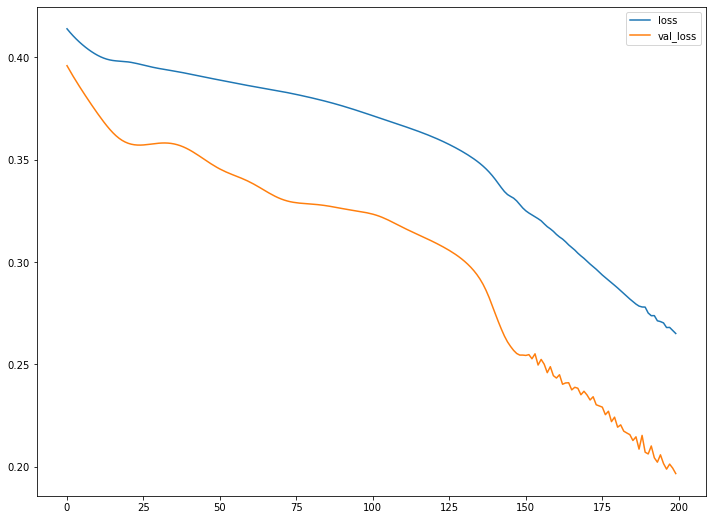

In [14]:
model1, his = t.train(EPOCHS)

In [15]:
# Set window of past points for LSTM model
window = 45

# # Split 80/20 into train/test data
last = int(len(train.Sales)/5.0)
Xtrain = train.Sales[:-last]
Xtest = train.Sales[-last-window:]

# # Store window number of points as a sequence
xin = []
next_X = []
for i in range(window, len(Xtrain)):
    try:
        xin.append(Xtrain[i-window:i])
        next_X.append(Xtrain[i])
    except Exception as e:
        print(f'i value : {i}')
        exit(0)

# Reshape data to format for LSTM
xin, next_X = np.array(xin), np.array(next_X)
xin = xin.reshape(xin.shape[0], xin.shape[1], 1)

# Model

In [16]:
# Initialize LSTM model
m = Sequential()
m.add(LSTM(units=50, return_sequences=True, input_shape=(xin.shape[1], 1)))
m.add(Dropout(0.2))
m.add(LSTM(units=50))
m.add(Dropout(0.2))
m.add(Dense(units=1))
m.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

In [17]:
# Fit LSTM model
history = m.fit(xin, next_X, epochs=700, batch_size=50, verbose=0)

2022/05/29 17:12:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1a51d2b7d37e4c4b95a8d02c26d2c2f6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


INFO:tensorflow:Assets written to: /tmp/tmpsrcfwjye/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpsrcfwjye/model/data/model/assets


# Forcasting

6/6 [==============================] - 1s 29ms/step


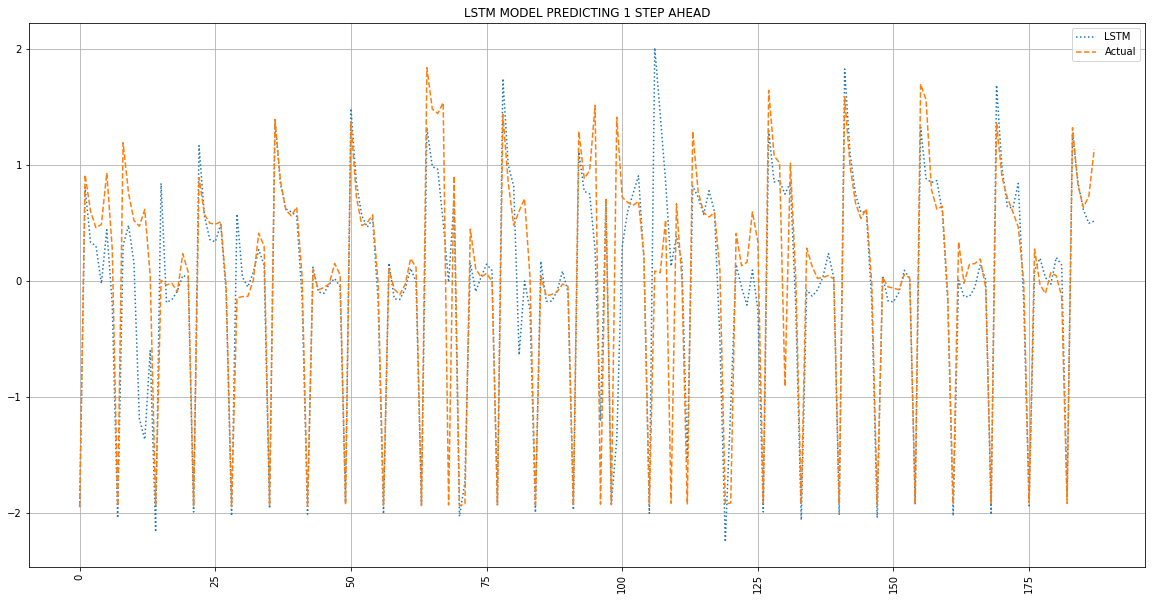

In [18]:
# Store "window" points as a sequence
xin = []
next_X1 = []
for i in range(window, len(Xtest)):
    xin.append(Xtest[i-window:i])
    next_X1.append(Xtest[i])

# Reshape data to format for LSTM
xin, next_X1 = np.array(xin), np.array(next_X1)
xin = xin.reshape((xin.shape[0], xin.shape[1], 1))

# Predict the next value (1 step ahead)
X_pred = m.predict(xin)

# Plot prediction vs actual for test data
plt.figure(figsize=(20, 10))
plt.title('LSTM MODEL PREDICTING 1 STEP AHEAD')
plt.xticks(rotation=90)
plt.grid()
plt.plot(X_pred, ':', label='LSTM')
plt.plot(next_X1, '--', label='Actual')
plt.legend()